<a href="https://colab.research.google.com/github/tahamsi/computer-vision/blob/main/generative-models/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/tahamsi/computer-vision)

#DDPM
Denoising Diffusion Probabilistic Models ([DDPMs](https://click.endnote.com/viewer?doi=10.48550/arXiv.2006.11239&route=6)) are a class of generative models introduced by Jonathan Ho, Ajay Jain, and Pieter Abbeel in 2020. These models generate data by reversing a diffusion process that incrementally adds noise to the data. By learning to reverse this noising process, DDPMs can produce high-quality samples from complex data distributions.

The process can be described in two main phases: the **forward** process (**diffusion**) and the **reverse** process (**generation**).

## Forward Diffusion Process (adding noise)
The forward process is where noise is gradually added to the data over a series of time steps. It starts with an image $𝑥_0$ (e.g., a picture of a cat). And gradually adds Gaussian noise to it over $𝑇$ steps using this formula:

$$q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \, \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I}).$$

Or

$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon.$$

where:
* $\bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_t)$
* $\beta_t$: A small variance schedule controlling how much noise is added at step $𝑡$
* $𝑥_𝑡$: Noisy image at step $𝑡$,

* $\epsilon$: Random (Gaussian) noise (like static on a TV).

By the end ($𝑡$ = $𝑇$), the image looks like pure noise.

## Reverse Process (Denoising)
The model (a neural network) learns to reverse this noise-adding process step-by-step to recover the original image or generate a new one. The reverse process is defined as:

$$p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_t, t), \Sigma_\theta(\mathbf{x}_t, t)).$$

Where:
* $\mu_\theta(\mathbf{x}_t, t)$: The predicted mean, parameterized by a neural network.
* $\Sigma_\theta(\mathbf{x}_t, t)$: The variance, often fixed for simplicity.

In another word, at each step, the model predicts the noise $\epsilon_θ(x_t,t)$ using a neural network and removes it:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \sqrt{1 - \alpha_t} \, \epsilon_\theta(x_t, t) \right).$$

where:
* $x_{t-1}$: The less noisy image at step $𝑡-1$,
* $\epsilon_\theta(x_t, t)$: Noise predicted by the model.

The process is repeated until a clean image is generated.


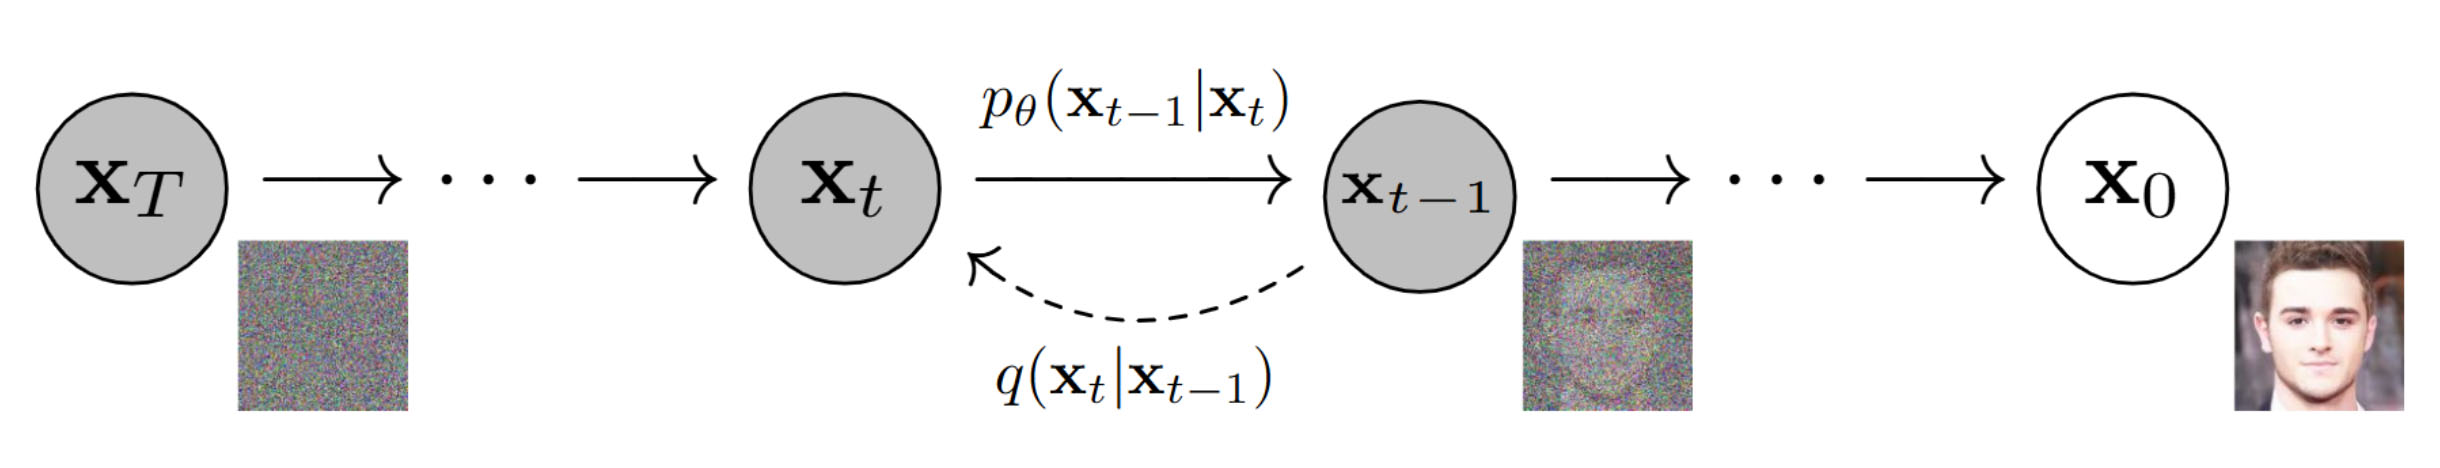

## Loss Function
To train the model, we calculate how well it predicts the noise $ϵ$. The simplified loss function is:
$$\mathcal{L}_t = \mathbb{E}_q \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]$$.

This measures the difference between:

* $\epsilon$: The actual noise added,
* $\epsilon_\theta(x_t, t)$: The noise predicted by the model.

## Full Objective
The total loss over all $𝑇$ timesteps is:

$$\mathcal{L} = \sum_{t=1}^T \mathcal{L}_t = \mathbb{E}_q \left[ \sum_{t=1}^T \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]$$

## Why It Works
* The model learns to reverse the noisy process, step by step.
* By minimizing $\mathcal{L}$, it becomes better at reconstructing $x_0$ or generating new, realistic data from noise.


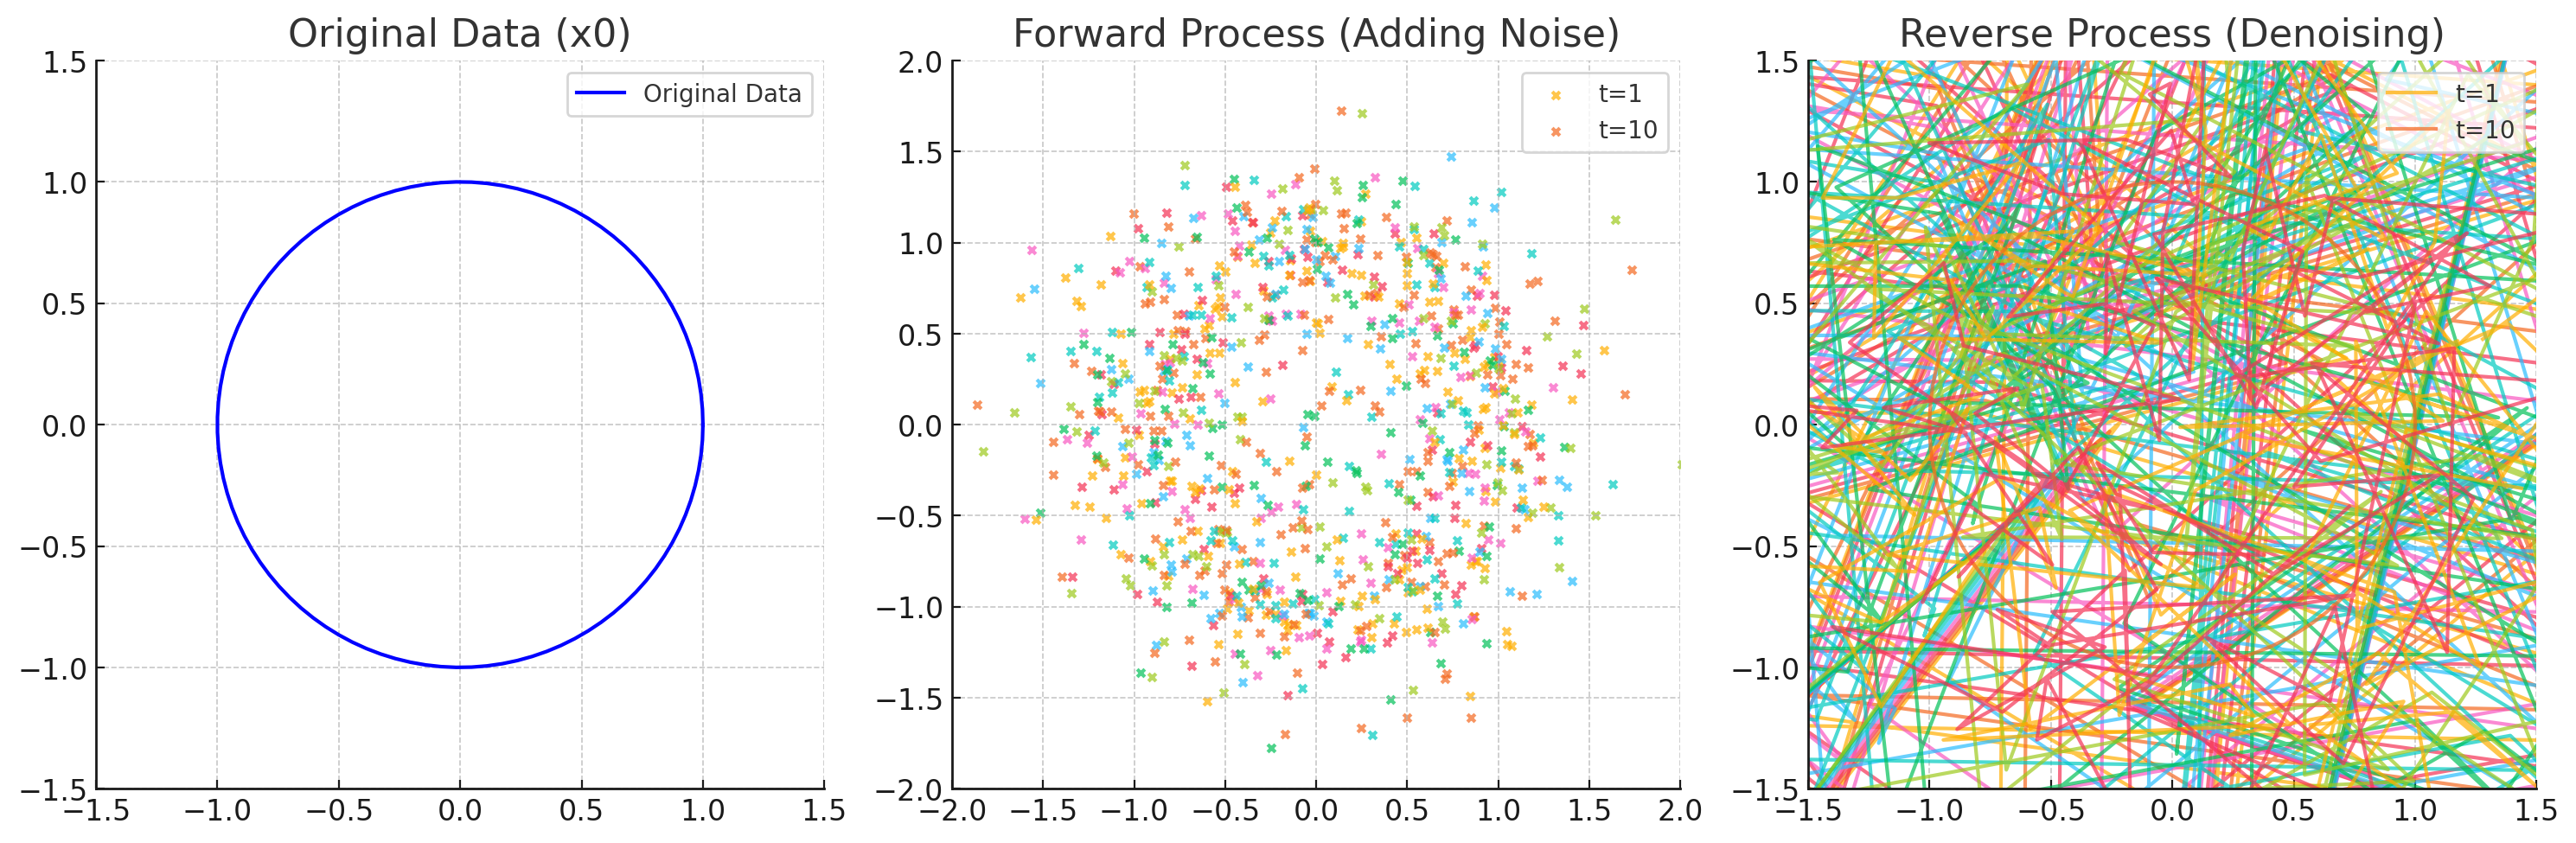

* Original Data (left): A circle representing the clean data $x_0$.
* Forward Process (middle): Gradual addition of noise over time, turning the data into a noisy state.
* Reverse Process (right): Step-by-step denoising to reconstruct the original data from noise.

## Key Ideas in Simple Terms
* Forward Process: Gradually make the image noisier.
* Reverse Process: Teach the model to remove the noise step-by-step.
* Final Output: A clear image generated from random noise.


##Why It’s Powerful
* Produces high-quality images.
* Stable to train compared to other methods like GANs.
* Can handle tasks like:
 * Image generation (e.g., create art from scratch).
 *Denoising (e.g., clean up blurry or noisy images).
 *Inpainting (e.g., fill in missing parts of an image).

This simplified process is the foundation of tools like [Stable Diffusion](https://github.com/tahamsi/computer-vision/blob/main/generative-models/Image_Generation_with_Stable_Diffusion.ipynb) for generating images from text!

## Before you start

Let's make sure that we have access to `GPU`. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit -> Notebook settings -> Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

In [ ]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

Here, \\(\mathbf{x}_0\\) is the initial (real, uncorruped) image, and we see the direct noise level \\(t\\) sample given by the fixed forward process. \\(\mathbf{\epsilon}\\) is the pure noise sampled at time step \\(t\\), and \\(\mathbf{\epsilon}_\theta (\mathbf{x}_t, t)\\) is our neural network. The neural network is optimized using a simple mean squared error (MSE) between the true and the predicted Gaussian noise.

The training algorithm now looks as follows:


<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

In other words:
* we take a random sample $\mathbf{x}_0$ from the real unknown and possibily complex data distribution $q(\mathbf{x}_0)$
* we sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* we sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ using the nice property defined above
* the neural network is trained to predict this noise based on the corruped image $\mathbf{x}_t$, i.e. noise applied on $\mathbf{x}_0$ based on known schedule $\beta_t$

In reality, all of this is done on batches of data as one uses stochastic gradient descent to optimize neural networks.

## The neural network

The neural network needs to take in a noised image at a particular time step and return the predicted noise. Note that the predicted noise is a tensor that has the same size/resolution as the input image. So technically, the network takes in and outputs tensors of the same shape. What type of neural network can we use for this?

Autoencoders have a so-called "bottleneck" layer in between the encoder and decoder. The encoder first encodes an image into a smaller hidden representation called the "bottleneck", and the decoder then decodes that hidden representation back into an actual image. This forces the network to only keep the most important information in the bottleneck layer.

In terms of architecture, the DDPM authors went for a **U-Net**, introduced by ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)) (which, at the time, achieved state-of-the-art results for medical image segmentation). This network, like any autoencoder, consists of a bottleneck in the middle that makes sure the network learns only the most important information. Importantly, it introduced residual connections between the encoder and decoder, greatly improving gradient flow (inspired by ResNet in [He et al., 2015](https://arxiv.org/abs/1512.03385)).

<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="400" />
</p>

As can be seen, a U-Net model first downsamples the input (i.e. makes the input smaller in terms of spatial resolution), after which upsampling is performed.

Below, we implement this network, step-by-step.

### Network helpers

First, we define some helper functions and classes which will be used when implementing the neural network. Importantly, we define a `Residual` module, which simply adds the input to the output of a particular function (in other words, adds a residual connection to a particular function).

We also define aliases for the up- and downsampling operations.

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$, inspired by the Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)). This makes the neural network "know" at which particular time step (noise level) it is operating, for every image in a batch.

The `SinusoidalPositionEmbeddings` module takes a tensor of shape `(batch_size, 1)` as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape `(batch_size, dim)`, with `dim` being the dimensionality of the position embeddings. This is then added to each residual block, as we will see further.

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet/ConvNeXT block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block ([Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)), but Phil Wang decided to also add support for a ConvNeXT block ([Liu et al., 2022](https://arxiv.org/abs/2201.03545)), as the latter has achieved great success in the image domain. One can choose one or another in the final U-Net architecture.

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. Attention is the building block of the famous Transformer architecture ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), which has shown great success in various domains of AI, from NLP and vision to [protein folding](https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology). Phil Wang employs 2 variants of attention: one is regular multi-head self-attention (as used in the Transformer), the other one is a [linear attention variant](https://github.com/lucidrains/linear-attention-transformer) ([Shen et al., 2018](https://arxiv.org/abs/1812.01243)), whose time- and memory requirements scale linear in the sequence length, as opposed to quadratic for regular attention.

For an extensive explanation of the attention mechanism, we refer the reader to Jay Allamar's [wonderful blog post](https://jalammar.github.io/illustrated-transformer/).

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization ([Wu et al., 2018](https://arxiv.org/abs/1803.08494)). Below, we define a `PreNorm` class, which will be used to apply groupnorm before the attention layer, as we'll see further. Note that there's been a [debate](https://tnq177.github.io/data/transformers_without_tears.pdf) about whether to apply normalization before or after attention in Transformers.

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet/ConvNeXT blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

- the network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + a downsample operation
* at the middle of the network, again ResNet or ConvNeXT blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + an upsample operation
* finally, a ResNet/ConvNeXT block followed by a convolutional layer is applied.

Ultimately, neural networks stack up layers as if they were lego blocks (but it's important to [understand how they work](http://karpathy.github.io/2019/04/25/recipe/)).


In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$. This happens according to a **variance schedule**. The original DDPM authors employed a linear schedule:

> We set the forward process variances to constants
increasing linearly from $\beta_1 = 10^{−4}$
to $\beta_T = 0.02$.

However, it was shown in ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)) that better results can be achieved when employing a cosine schedule.

Below, we define various schedules for the $T$ timesteps, as well as corresponding variables which we'll need, such as cumulative variances.

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [ ]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

<img src="https://drive.google.com/uc?id=17FXnvCTl96lDhqZ_io54guXO8hM-rsQ2" width="400" />

Noise is added to PyTorch tensors, rather than Pillow Images. We'll first define image transformations that allow us to go from a PIL image to a PyTorch tensor (on which we can add the noise), and vice versa.

These transformations are fairly simple: we first normalize images by dividing by $255$ (such that they are in the $[0,1]$ range), and then make sure they are in the $[-1, 1]$ range. From the DPPM paper:

> We assume that image data consists of integers in $\{0, 1, ... , 255\}$ scaled linearly to $[−1, 1]$. This
ensures that the neural network reverse process operates on consistently scaled inputs starting from
the standard normal prior $p(\mathbf{x}_T )$.


In [ ]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

x_start = transform(image).unsqueeze(0)
x_start.shape

In [ ]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

In [ ]:
reverse_transform(x_start.squeeze())

In [ ]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [ ]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [ ]:
# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

Visualisation

In [ ]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [ ]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

The `denoise_model` will be our U-Net defined above. We'll employ the Huber loss between the true and the predicted noise.

## Define a PyTorch Dataset + DataLoader

Here we define a regular [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). The dataset simply consists of images from a real dataset, like Fashion-MNIST, CIFAR-10 or ImageNet, scaled linearly to \\([−1, 1]\\).

Each image is resized to the same size. Interesting to note is that images are also randomly horizontally flipped. From the paper:

> We used random horizontal flips during training for CIFAR10; we tried training both with and without flips, and found flips to improve sample quality slightly.

Here we use the 🤗 [Datasets library](https://huggingface.co/docs/datasets/index) to easily load the Fashion MNIST dataset from the [hub](https://huggingface.co/datasets/fashion_mnist). This dataset consists of images which already have the same resolution, namely 28x28.

In [ ]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
print(batch.keys())

## Sampling

As we'll sample from the model during training (in order to track progress), we define the code for that below. Sampling is summarized in the paper as Algorithm 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="500" />

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. As shown above, we can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.

The code below implements this.

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [ ]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchvision.utils import save_image

epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

In [ ]:
# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

Seems like the model is capable of generating a nice T-shirt! Keep in mind that the dataset we trained on is pretty low-resolution (28x28).

We can also create a gif of the denoising process:

In [ ]:
import matplotlib.animation as animation

random_index = 53

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

### Install `diffusers`

In [ ]:
!pip install diffusers==0.11.1

### Overview

One goal of the diffusers library is to make diffusion models accessible to a wide range of deep learning practitioners.
With this in mind, we aimed at building a library that is **easy to use**, **intuitive to understand**, and **easy to contribute to**.

As a quick recap, diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*.

The underlying model, often a neural network, is trained to predict a way to slightly denoise the image in each step. After certain number of steps, a sample is obtained.

The process is illustrated by the following design:
![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusion-process.png)

The architecture of the neural network, referred to as **model**, commonly follows the UNet architecture as proposed in [this paper](https://arxiv.org/abs/1505.04597) and improved upon in the Pixel++ paper.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

No worries if you don't understand everything. Some of the highlights of the architecture are:
* this model predicts images of the same size as the input
* the model makes the input image go through several blocks of ResNet layers which halves the image size by 2
* then through the same number of blocks that upsample it again.
* skip connections link features on the downsample path to corresponding layers in the upsample path.


The diffusion process consists in taking random noise of the size of the desired output and pass it through the model several times. The process ends after a given number of steps, and the output image should represent a sample according to the training data distribution of the model, for instance an image of a butterfly.

During training we show many samples of a given distribution, such as images of butterfly. After training, the model will be able to process random noise to generate similar butterfly images.

Without going in too much detail, the model is usually not trained to directly predict a slightly less noisy image, but rather to predict the "noise residual" which is the difference between a less noisy image and the input image (for a diffusion model called "DDPM") or, similarly, the gradient between the two time steps (like the diffusion model called "Score VE").

To do the denoising process, a specific noise scheduling algorithm is thus necessary and "wrap" the model to define how many diffusion steps are needed for inference as well as how to *compute* a less noisy image from the model's output. Here is where the different **schedulers** of the diffusers library come into play.

Finally, a **pipeline** groups together a **model** and a **scheduler** and make it easy for an end-user to run a full denoising loop process. We'll start with the pipelines and dive deeper into its implementation before taking a closer look at models and schedulers.

## Core API

### Pipelines

Let's begin by importing a pipeline. We'll use the `google/ddpm-celebahq-256` model, built in collaboration by Google and U.C.Berkeley. It's a model following the [Denoising Diffusion Probabilistic Models (DDPM) algorithm](https://arxiv.org/abs/2006.11239) trained on a dataset of celebrities images.

We can import the `DDPMPipeline`, which will allow you to do inference with a couple of lines of code:

In [ ]:
from diffusers import DDPMPipeline

The `from_pretrained()` method allows downloading the model and its configuration from [the Hugging Face Hub](https://huggingface.co/google/ddpm-celebahq-256), a repository of over 60,000 models shared by the community.


In [ ]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to("cuda")

To generate an image, we simply run the pipeline and don't even need to give it any input, it will generate a random initial noise sample and then iterate the diffusion process.

The pipeline returns as output a dictionary with a generated `sample` of interest. This will typically take 2-3 minutes on Google Colab:

In [ ]:
images = image_pipe().images

Let's take a look 🙂

In [ ]:
images[0]

Looks pretty good!

Now, let's try to understand a bit better what was going on under the hood. Let's see what the pipeline is made of:

In [ ]:
image_pipe

We can see inside the pipeline a scheduler and a UNet model. Let's have a closer look at them and what this pipeline just did behind the scenes.

### Models

Instances of the model class are neural networks that take a noisy `sample` as well as a `timestep` as inputs to predict a less noisy output `sample`. Let's load a pre-trained model and play around with it to understand the model API!

We'll load a simple unconditional image generation model of type `UNet2DModel` which was released with the [DDPM Paper](https://arxiv.org/abs/2006.11239) and for instance take a look at another checkpoint trained on church images: [`google/ddpm-church-256`](https://huggingface.co/google/ddpm-church-256).

Similarly to what we've seen for the pipeline class, we can load the model configuration and weights with one line, using the `from_pretrained()` method that you may be familiar with if you've played with the `transformers` library:

In [ ]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

The `from_pretrained()` method caches the model weights locally, so if you execute the cell above a second time, it will go much faster. The model is a pure PyTorch `torch.nn.Module` class which you can see when printing out `model`.

In [ ]:
model

Now let's take a look at the model's configuration. The configuration can be accessed via the `config` attribute and shows all the necessary parameters to define the model architecture (and only those).

In [ ]:
model.config

As you can see, the model config is a frozen dictionary. This is to enforce that the configuration will **only** be used to define the model architecture at instantiation time and not for any attributes that can be changed during inference.

A couple of important config parameters are:
- `sample_size`: defines the `height` and `width` dimension of the input sample.
- `in_channels`: defines the number of input channels of the input sample.
- `down_block_types` and `up_block_types`: define the type of down- and upsampling blocks that are used to create the UNet architecture as was seen in the figure at the beginning of this notebook.
- `block_out_channels`: defines the number of output channels of the downsampling blocks, also used in reversed order for the number of input channels of the upsampling blocks.
- `layers_per_block`: defines how many ResNet blocks are present in each UNet block.

Knowing how a UNet config looks like, you can quickly try to instantiate the exact same model architecture with random weights. To do so, let's pass the config as an unpacked dict to the `UNet2DModel` class.

In [ ]:
model_random = UNet2DModel(**model.config)

Cool, the above created a randomly initialized model with the same config as the previous one.

If you want to save the model you just created, you can use the `save_pretrained()` method, which saves both the model weights as well as the model config in the provided folder.

In [ ]:
model_random.save_pretrained("my_model")

Let's take a look at what files were saved in `my_model`.

In [ ]:
!ls my_model

`diffusion_pytorch_model.bin` is a binary PyTorch file that stores the model weights and `config.json` stores the model's configuration.

If you want to reuse the model, you can simply use the `from_pretrained()` method again, as it loads local checkpoints as well as those present on the Hub.

In [ ]:
model_random = UNet2DModel.from_pretrained("my_model")

Coming back to the actually trained model, let's now see how you can use the model for inference. First, you need a random gaussian sample in the shape of an image (`batch_size` $\times$ `in_channels` $\times$ `sample_size` $\times$ `sample_size`). We have a `batch` axis because a model can receive multiple random noises, a `channel` axis because each one consists of multiple channels (such as red-green-blue), and finally `sample_size` corresponds to the height and width.

In [ ]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

Time to do the inference!

You can pass the noisy sample alongside a `timestep` through the model. The timestep is important to cue the model with "how noisy" the input image is (more noisy in the beginning of the process, less noisy at the end), so the model knows if it's closer to the start or the end of the diffusion process.

As explained in the introduction, the model predicts either the slightly less noisy image, the difference between the slightly less noisy image and the input image or even something else. It is important to carefully read through the [model card](https://huggingface.co/google/ddpm-church-256) to know what the model has been trained on. In this case, the model predicts the noise residual (difference between the slightly less noisy image and the input image).

In [ ]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

The predicted `noisy_residual` has the exact same shape as the input and we use it to compute a slightly less noised image. Let's confirm the output shapes match:

In [ ]:
noisy_residual.shape

Great.

Now to summarize, **models**, such as `UNet2DModel` (PyTorch modules) are parameterized neural networks trained to *predict* a slightly less noisy image or residual. They are defined by their `.config` and can be loaded from the Hub as well as saved and loaded locally. The next step is learning how to combine this **model** with the correct **scheduler** to be able to actually generate images.

### Schedulers

**Schedulers** are algorithms wrapped into a Python class. They define the noise schedule which is used to add noise to the model during training, and also define the algorithm to *compute* the slightly less noisy sample given the model output (here `noisy_residual`). This notebook focuses only on how to use *scheduler* classes for inference. You can check out this notebook to see how to use *schedulers* for training.

It is important to stress here that while *models* have trainable weights, *schedulers* are usually *parameter-free* (in the sense they have no trainable weights) and simply define the algorithm to compute the slightly less noisy sample. Schedulers thus don't inherit from `torch.nn.Module`, but like models they are instantiated by a configuration.

To download a scheduler config from the Hub, you can make use of the `from_config()` method to load a configuration and instantiate a scheduler.

Let's use `DDPMScheduler`, the denoising algorithm proposed in the [DDPM Paper](https://arxiv.org/abs/2006.11239).

In [ ]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)

Let's also take a look at the config here

In [ ]:
scheduler.config

Different schedulers are usually defined by different parameters. To better understand what the parameters are used for exactly, the reader is advised to directly look into the respective scheduler files under `src/diffusers/schedulers/`, such as the [`src/diffusers/schedulers/scheduling_ddpm.py`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddpm.py) file. Here are the most important ones:
- `num_train_timesteps` defines the length of the denoising process, e.g. how many timesteps are need to process random gaussian noise to a data sample.
- `beta_schedule` define the type of noise schedule that shall be used for inference and training
- `beta_start` and `beta_end` define the smallest noise value and highest noise value of the schedule.

Like the *models*, *schedulers* can be saved and loaded with `save_config()` and `from_config()`.


In [ ]:
scheduler.save_config("my_scheduler")
new_scheduler = DDPMScheduler.from_config("my_scheduler")

All schedulers provide one or multiple `step()` methods that can be used to compute the slightly less noisy image. The `step()` method may vary from one scheduler to another, but normally expects at least the model output, the `timestep` and the current `noisy_sample`.

Note that the `step()` method is somewhat of a black box function that "just works". If you are keen to better understand how exactly the previous noisy sample is computed as defined in the original paper of the scheduler, you should take a look at the actual code, *e.g.* [click here](https://github.com/huggingface/diffusers/blob/936cd08488260a9df3548d66628b83bc7f26bd9e/src/diffusers/schedulers/scheduling_ddpm.py#L130) for DDPM, which contains comments and references to the original paper.

Let's give it a try using the model output from the previous section.

In [ ]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

You can see that the computed sample has the exact same shape as the model input, meaning that you are ready to pass it to the model again in a next step.

Let's now bring it all together and actually define the denoising loop. This loop prints out the (less and less) noisy samples along the way for better visualization in the denoising loop. Let's define a display function that takes care of post-processing the denoised image, convert it to a `PIL.Image` and displays it.

In [ ]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

Before defining the loop, let's move the input and model to the GPU to speed up the denoising process a bit.

In [ ]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

Time to finally define the denoising loop! It is rather straight-forward for DDPM.

1. Predict the residual of the less noisy sample with the model.
2. Compute the less noisy sample with the scheduler.

Additionally, at every 50th step this will display the progress.

It's important to note here that you loop over `scheduler.timesteps` which is a tensor defining the sequence of timesteps over which to iterate during the denoising process. Usually, the denoising process goes in decreasing order of timesteps, so from the total number of timesteps (here 1000) to 0.

Depending on your GPU this might take up to a minute - enough time to reflect on everything you learned so far while you can watch a church being built from nothing but noise ⛪.

In [ ]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

You can see that it takes quite some time to see a somewhat meaningful shape - only after *ca.* 800 steps.

While the quality of the image is actually quite good - you might want to speed up the image generation.

To do so, you can try replacing the DDPM scheduler with the [DDIM](https://arxiv.org/abs/2010.02502) scheduler which keep high generation quality at significantly sped-up generation time.

**Exchanging schedulers**: one of the exciting prospects of a diffusion model library is that different scheduling protocols can work with different models, but there is not a one-sized fits all solution!
In this case, DDIM worked as an swap for DDPM, but this not universal (and represents an interesting research problem).


In [ ]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_config(repo_id)

The DDIM scheduler allows the user to define how many denoising steps should be run at inference via the `set_timesteps` method. The DDPM scheduler runs by default 1000 denoising steps. Let's significantly reduce this number to just 50 inference steps for DDIM.

In [ ]:
scheduler.set_timesteps(num_inference_steps=50)

And you can run the same loop as before - only that you are now making use of the much faster DDIM scheduler.

In [ ]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute previous image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      display_sample(sample, i + 1)

You can see that the image generation is indeed much faster - a mere two seconds - but also that you pay by giving away image quality in exchange for speed.

Cool, now you should have gotten a good first understanding of the schedulers. The important things to remember are:
1. schedulers are *parameter-free* (no trainable weights)
2. schedulers define the algorithm computing the slightly less noisy sample during inference

They are many schedulers already added to `diffusers` and diffusers will be adding even more in the future. It's important that you read the model cards to understand which model checkpoints can be used with which schedulers.
You can find all available schedulers [here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers).

To end the chapter about **models** and **schedulers**, please also note that we very much *deliberately* try to keep *models* and *schedulers* as independent from each other as possible. This means a `scheduler` should never accept a `model` as an input and vice-versa. The model *predict* the noise residual or slightly less noisy image with its trained weights, while the scheduler *computes* the previous sample given the model's output.